# 天池工业AI

In [1]:
import xgboost as xgb
import pandas as pd
import numpy as np
import pickle
import sys
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error, make_scorer
from sklearn.preprocessing import StandardScaler
from sklearn.grid_search import GridSearchCV
from scipy.sparse import csr_matrix, hstack
from sklearn.cross_validation import KFold, train_test_split
from xgboost import XGBRegressor

import warnings
warnings.filterwarnings('ignore')

%matplotlib inline

# This may raise an exception in earlier versions of Jupyter
%config InlineBackend.figure_format = 'retina'

C:\Program Files\setup\Anaconda\lib\site-packages\sklearn\cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
C:\Program Files\setup\Anaconda\lib\site-packages\sklearn\grid_search.py:43: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. This module will be removed in 0.20.
  DeprecationWarning)


In [15]:
USE_PRETRAINED = False

In [16]:

test = pd.read_excel('data/testA_20180117.xlsx')

In [33]:
train = pd.read_csv('train_2644.csv')

In [53]:
x_train = train.iloc[:,1:-1] 
y_train = train.iloc[:,-1]

In [35]:
y_train.shape

(800,)

In [8]:
features = [x for x in train.columns if x not in ['id','Y']]

cat_features = [x for x in train.select_dtypes(
        include=['object']).columns if x not in ['id','Y']]
num_features = [x for x in train.select_dtypes(
        exclude=['object']).columns if x not in ['id','Y']]

print ("Categorical features:", len(cat_features))
print ("Numerical features:", len(num_features))

Categorical features: 0
Numerical features: 186


In [252]:
x_train.to_csv('x_train.csv')

## Simple XGBoost Model

In [54]:
from sklearn.metrics import mean_squared_error
def xg_eval_mae(yhat, dtrain):
    y = dtrain.get_label()
    return 'mae', mean_squared_error(y, yhat)

In [55]:
dtrain = xgb.DMatrix(x_train, y_train)

In [56]:
dtrain

In [153]:
xgb_params = {
    'seed': 0,
    'eta': 0.1,
    'learning_rate':0.1,
    'colsample_bytree': 0.6,
    'silent': 1,
    'subsample': 0.7,
    'objective': 'reg:linear',
    'max_depth':3,
    'min_child_weight': 3,
    'reg_lambda':0.2,
    'reg_alpha':1,
    'gamma':0.3
}

In [154]:
%%time

if USE_PRETRAINED: 
    with open('pretrained/xgb_bst_cv1.pkl', 'rb') as f:
        bst_cv1 = pickle.load(f)
        
else:
    bst_cv1 = xgb.cv(xgb_params, dtrain, num_boost_round=100, nfold=5, seed=0, 
                    feval=xg_eval_mae, maximize=False)

print ('CV score:', bst_cv1.iloc[-1,:]['test-rmse-mean']**2)
print ('train score:', bst_cv1.iloc[-1,:]['train-rmse-mean']**2)

CV score: 0.0207920826692
train score: 0.014216508289
Wall time: 8.7 s


In [148]:
bst_cv1.iloc[-1,:]

test-mae-mean      0.022910
test-mae-std       0.003095
test-rmse-mean     0.151023
test-rmse-std      0.010105
train-mae-mean     0.016150
train-mae-std      0.000305
train-rmse-mean    0.127075
train-rmse-std     0.001202
Name: 99, dtype: float64

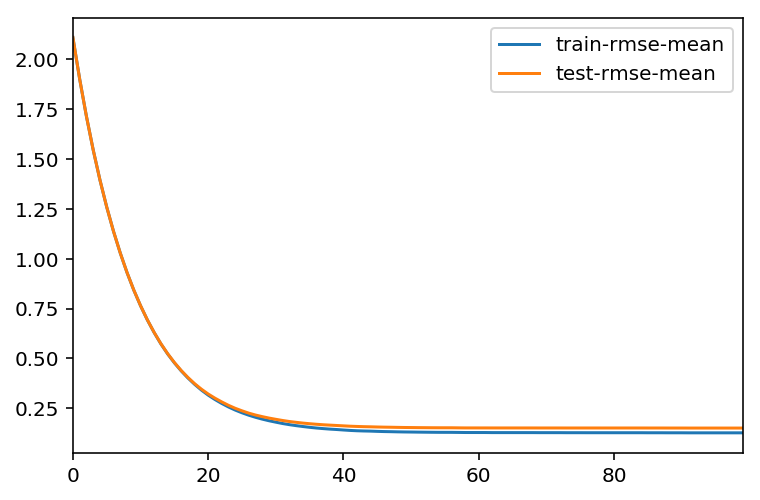

In [149]:
plt.figure()
bst_cv1[['train-rmse-mean', 'test-rmse-mean']].plot()

In [150]:
x_test = test[x_train.columns]
dtest = xgb.DMatrix(x_test) 
bst = xgb.train(xgb_params, dtrain, num_boost_round=100) 
y_predA = bst.predict(dtest)


In [151]:
y_predA

array([ 2.83944058,  2.83368778,  2.85871005,  2.79803753,  2.8502636 ,
        2.70089912,  2.89752746,  3.08800602,  3.04475999,  3.04938626,
        3.09378982,  2.84746957,  2.82733655,  2.7634635 ,  2.88206482,
        2.76845932,  2.86706805,  2.71428847,  2.8093617 ,  2.59914851,
        2.80652857,  2.84549904,  2.7717011 ,  2.82749987,  2.86544204,
        2.7775178 ,  2.81504011,  2.89960122,  2.79187059,  2.68508983,
        2.62308526,  2.57302523,  2.76085353,  2.68064618,  2.72171497,
        2.68064618,  2.64854574,  2.89218688,  2.8331809 ,  2.81177306,
        2.75058079,  2.91717887,  2.90295291,  2.78774524,  2.80740762,
        2.76306081,  2.76595235,  2.89312172,  2.80423975,  2.76735592,
        2.81052017,  2.694695  ,  2.82164097,  2.7601428 ,  2.72716856,
        2.70430207,  2.7472167 ,  2.76777482,  2.75089979,  2.71683884,
        2.7380383 ,  2.59683704,  2.69895625,  2.57367134,  2.64254546,
        2.7492907 ,  2.57472134,  2.62231922,  2.61219192,  2.79

In [152]:
subA = pd.read_csv('data/answer_sample_a_20180117.csv', header = None)
subA['Y'] = y_predA
subA.to_csv('result/fu_subA2_26.csv',header=None, index=False)

In [205]:
%%time
if USE_PRETRAINED:
     with open('pretrained/xgb_bst_cv2.pkl', 'rb') as f:
        bst_cv2 = pickle.load(f)
else:
    bst_cv2 = xgb.cv(xgb_params, dtrain, num_boost_round=1000, 
                    nfold=10, seed=0, feval=xg_eval_mae, maximize=False, 
                    early_stopping_rounds=10)

print ('CV score:', bst_cv2.iloc[-1,:]['test-rmse-mean']**2)

CV score: 0.0376562175144
Wall time: 6.36 s


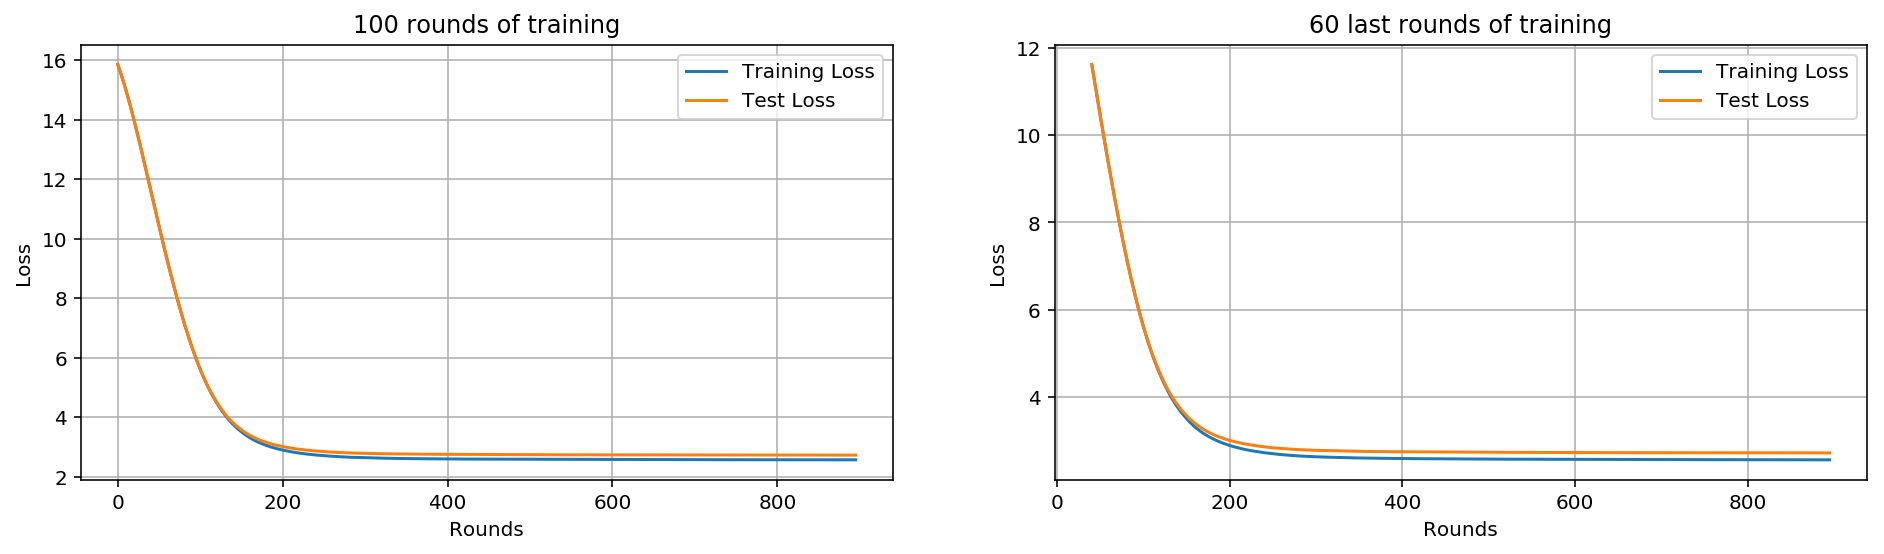

In [206]:
fig, (ax1, ax2) = plt.subplots(1,2)
fig.set_size_inches(16,4)

ax1.set_title('100 rounds of training')
ax1.set_xlabel('Rounds')
ax1.set_ylabel('Loss')
ax1.grid(True)
ax1.plot(bst_cv2[['train-mae-mean', 'test-mae-mean']])
ax1.legend(['Training Loss', 'Test Loss'])

ax2.set_title('60 last rounds of training')
ax2.set_xlabel('Rounds')
ax2.set_ylabel('Loss')
ax2.grid(True)
ax2.plot(bst_cv2.iloc[40:][['train-mae-mean', 'test-mae-mean']])
ax2.legend(['Training Loss', 'Test Loss'])

## XGBoost Tuning

In [163]:
# To follow conventional function names in sklearn, we implement fit and predict functions
class XGBoostRegressor(object):
    def __init__(self, **kwargs):
        self.params = kwargs
        if 'num_boost_round' in self.params:
            self.num_boost_round = self.params['num_boost_round']
        self.params.update({'silent': 1, 'objective': 'reg:linear', 'seed': 0})
        
    def fit(self, x_train, y_train):
        dtrain = xgb.DMatrix(x_train, y_train)
        self.bst = xgb.train(params=self.params, dtrain=dtrain, num_boost_round=self.num_boost_round,
                             feval=xg_eval_mae, maximize=False)
        
    def predict(self, x_pred):
        dpred = xgb.DMatrix(x_pred)
        return self.bst.predict(dpred)
    
    def kfold(self, x_train, y_train, nfold=5):
        dtrain = xgb.DMatrix(x_train, y_train)
        cv_rounds = xgb.cv(params=self.params, dtrain=dtrain, num_boost_round=self.num_boost_round,
                           nfold=nfold, feval=xg_eval_mae, maximize=False, early_stopping_rounds=10)
        return cv_rounds.iloc[-1,:]
    
    def plot_feature_importances(self):
        feat_imp = pd.Series(self.bst.get_fscore()).sort_values(ascending=False)
        feat_imp.plot(title='Feature Importances')
        plt.ylabel('Feature Importance Score')
        
    def get_params(self, deep=True):
        return self.params
 
    def set_params(self, **params):
        self.params.update(params)
        return self

In [164]:
from sklearn.metrics import mean_squared_error
def mse_score(y_true, y_pred):
    return mean_squared_error(y_true, y_pred)

mse_scorer = make_scorer(mse_score, greater_is_better=False)

In [128]:
bst = XGBoostRegressor(eta=0.1, colsample_bytree=0.5, subsample=0.5, 
                       max_depth=5, min_child_weight=3, num_boost_round=500)

In [129]:
bst.kfold(x_train, y_train, nfold=5)

test-mae-mean      2.431763
test-mae-std       0.145465
test-rmse-mean     0.172939
test-rmse-std      0.010466
train-mae-mean     1.373962
train-mae-std      0.028781
train-rmse-mean    0.098838
train-rmse-std     0.001191
Name: 49, dtype: float64

In [138]:
xgb_param_grid = {'max_depth': list(range(2,7)), 'min_child_weight': (1,3,6)}

In [139]:
%%time

if USE_PRETRAINED:
    with open('pretrained/xgb_grid_max_depth.pkl', 'rb') as f: 
        grid = pickle.load(f)
else:    
    grid = GridSearchCV(XGBoostRegressor(eta=0.1, num_boost_round=50, colsample_bytree=0.5, subsample=0.5),
                    param_grid=xgb_param_grid, cv=5, scoring=mse_scorer)

    grid.fit(x_train, y_train)

Wall time: 1.23 s


In [140]:
grid.grid_scores_, grid.best_params_, grid.best_score_

([mean: -0.03408, std: 0.00560, params: {'max_depth': 2, 'min_child_weight': 1},
  mean: -0.03346, std: 0.00616, params: {'max_depth': 2, 'min_child_weight': 3},
  mean: -0.03358, std: 0.00546, params: {'max_depth': 2, 'min_child_weight': 6},
  mean: -0.03430, std: 0.00655, params: {'max_depth': 3, 'min_child_weight': 1},
  mean: -0.03298, std: 0.00540, params: {'max_depth': 3, 'min_child_weight': 3},
  mean: -0.03197, std: 0.00491, params: {'max_depth': 3, 'min_child_weight': 6},
  mean: -0.03346, std: 0.00596, params: {'max_depth': 4, 'min_child_weight': 1},
  mean: -0.03438, std: 0.00707, params: {'max_depth': 4, 'min_child_weight': 3},
  mean: -0.03298, std: 0.00641, params: {'max_depth': 4, 'min_child_weight': 6},
  mean: -0.03513, std: 0.00550, params: {'max_depth': 5, 'min_child_weight': 1},
  mean: -0.03352, std: 0.00581, params: {'max_depth': 5, 'min_child_weight': 3},
  mean: -0.03247, std: 0.00595, params: {'max_depth': 5, 'min_child_weight': 6},
  mean: -0.03566, std: 0.006

In [141]:
def convert_grid_scores(scores):
    _params = []
    _params_mae = []    
    for i in scores:
        _params.append(i[0].values())
        _params_mae.append(i[1])
    params = np.array(_params)
    grid_res = np.column_stack((_params,_params_mae))
    return [grid_res[:,i] for i in range(grid_res.shape[1])]

In [142]:
 _, scores =  convert_grid_scores(grid.grid_scores_)
scores = scores.reshape(5,3)

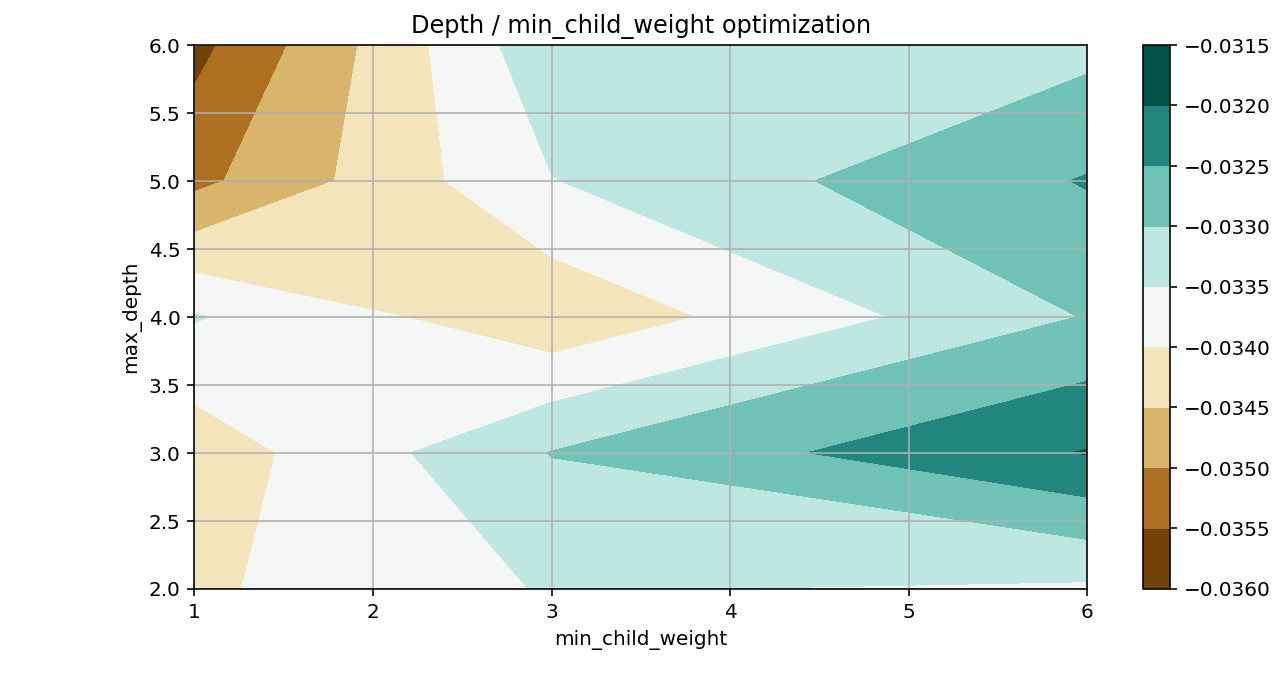

In [143]:
plt.figure(figsize=(10,5))
cp = plt.contourf(xgb_param_grid['min_child_weight'], xgb_param_grid['max_depth'], scores, cmap='BrBG')
plt.colorbar(cp)
plt.title('Depth / min_child_weight optimization')
plt.annotate('We use this', xy=(5.95, 7.95), xytext=(4, 7.5), arrowprops=dict(facecolor='white'), color='white')
plt.annotate('Good for depth=7', xy=(5.98, 7.05), 
             xytext=(4, 6.5), arrowprops=dict(facecolor='white'), color='white')
plt.xlabel('min_child_weight')
plt.ylabel('max_depth')
plt.grid(True)
plt.show()

In [144]:
%%time

if USE_PRETRAINED:
    with open('pretrained/xgb_grid_gamma.pkl', 'rb') as f: 
        grid = pickle.load(f)
    
else:
    xgb_param_grid = {'gamma':[ 0.1 * i for i in range(0,5)]}

    grid = GridSearchCV(XGBoostRegressor(eta=0.1, num_boost_round=50, max_depth=8, min_child_weight=6,
                                         colsample_bytree=0.5, subsample=0.5),
                        param_grid=xgb_param_grid, cv=5, scoring=mse_scorer)

    grid.fit(x_train, y_train)

Wall time: 591 ms


In [145]:
grid.grid_scores_, grid.best_params_, grid.best_score_

([mean: -0.03303, std: 0.00511, params: {'gamma': 0.0},
  mean: -0.03254, std: 0.00582, params: {'gamma': 0.1},
  mean: -0.03349, std: 0.00586, params: {'gamma': 0.2},
  mean: -0.03375, std: 0.00681, params: {'gamma': 0.30000000000000004},
  mean: -0.03520, std: 0.00712, params: {'gamma': 0.4}],
 {'gamma': 0.1},
 -0.032543504656442054)

In [146]:
%%time

xgb_param_grid = {'subsample':[ 0.1 * i for i in range(5,10)],
                      'colsample_bytree':[ 0.1 * i for i in range(5,10)]}

if USE_PRETRAINED: 
    with open('pretrained/xgb_grid_search_sampling.pkl', 'rb') as f:
        grid = pickle.load(f)
else:
    grid = GridSearchCV(XGBoostRegressor(eta=0.1, gamma=0.2, num_boost_round=50, max_depth=8, min_child_weight=6),
                        param_grid=xgb_param_grid, cv=5, scoring=mse_scorer)
    grid.fit(x_train, y_train)

Wall time: 3.64 s


In [70]:
grid.grid_scores_, grid.best_params_, grid.best_score_

([mean: -0.03349, std: 0.00586, params: {'colsample_bytree': 0.5, 'subsample': 0.5},
  mean: -0.03305, std: 0.00715, params: {'colsample_bytree': 0.5, 'subsample': 0.6000000000000001},
  mean: -0.03381, std: 0.00683, params: {'colsample_bytree': 0.5, 'subsample': 0.7000000000000001},
  mean: -0.03345, std: 0.00627, params: {'colsample_bytree': 0.5, 'subsample': 0.8},
  mean: -0.03340, std: 0.00668, params: {'colsample_bytree': 0.5, 'subsample': 0.9},
  mean: -0.03391, std: 0.00716, params: {'colsample_bytree': 0.6000000000000001, 'subsample': 0.5},
  mean: -0.03383, std: 0.00775, params: {'colsample_bytree': 0.6000000000000001, 'subsample': 0.6000000000000001},
  mean: -0.03302, std: 0.00621, params: {'colsample_bytree': 0.6000000000000001, 'subsample': 0.7000000000000001},
  mean: -0.03369, std: 0.00633, params: {'colsample_bytree': 0.6000000000000001, 'subsample': 0.8},
  mean: -0.03394, std: 0.00682, params: {'colsample_bytree': 0.6000000000000001, 'subsample': 0.9},
  mean: -0.0341

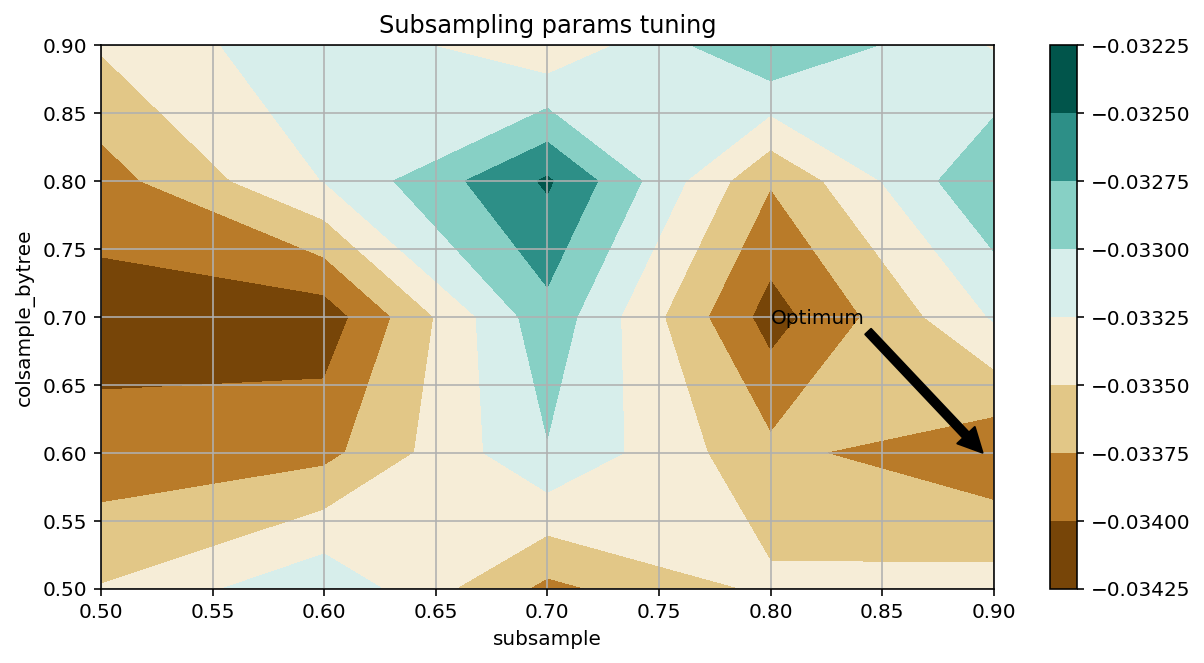

In [71]:
 _, scores =  convert_grid_scores(grid.grid_scores_)
scores = scores.reshape(5,5)

plt.figure(figsize=(10,5))
cp = plt.contourf(xgb_param_grid['subsample'], xgb_param_grid['colsample_bytree'], scores, cmap='BrBG')
plt.colorbar(cp)
plt.title('Subsampling params tuning')
plt.annotate('Optimum', xy=(0.895, 0.6), xytext=(0.8, 0.695), arrowprops=dict(facecolor='black'))
plt.xlabel('subsample')
plt.ylabel('colsample_bytree')
plt.grid(True)
plt.show()

In [184]:
%%time

if USE_PRETRAINED:
    with open('pretrained/xgb_grid_search_eta_50.pkl', 'rb') as f:
        grid = pickle.load(f)
else:      
    xgb_param_grid = {'eta':[0.5,0.4,0.3,0.2,0.1,0.075,0.05,0.04,0.03]}
    grid = GridSearchCV(XGBoostRegressor(num_boost_round=50, gamma=0.2, max_depth=8, min_child_weight=6,
                                         colsample_bytree=0.6, subsample=0.9),
                        param_grid=xgb_param_grid, cv=5, scoring=mse_scorer)

    grid.fit(x_train, y_train)

Wall time: 1.23 s


In [185]:
grid.grid_scores_, grid.best_params_, grid.best_score_

([mean: -0.03726, std: 0.00751, params: {'eta': 0.5},
  mean: -0.03631, std: 0.00724, params: {'eta': 0.4},
  mean: -0.03561, std: 0.00632, params: {'eta': 0.3},
  mean: -0.03379, std: 0.00614, params: {'eta': 0.2},
  mean: -0.03394, std: 0.00682, params: {'eta': 0.1},
  mean: -0.03586, std: 0.00782, params: {'eta': 0.075},
  mean: -0.06835, std: 0.01240, params: {'eta': 0.05},
  mean: -0.13216, std: 0.01923, params: {'eta': 0.04},
  mean: -0.30725, std: 0.02933, params: {'eta': 0.03}],
 {'eta': 0.2},
 -0.03379167882251784)

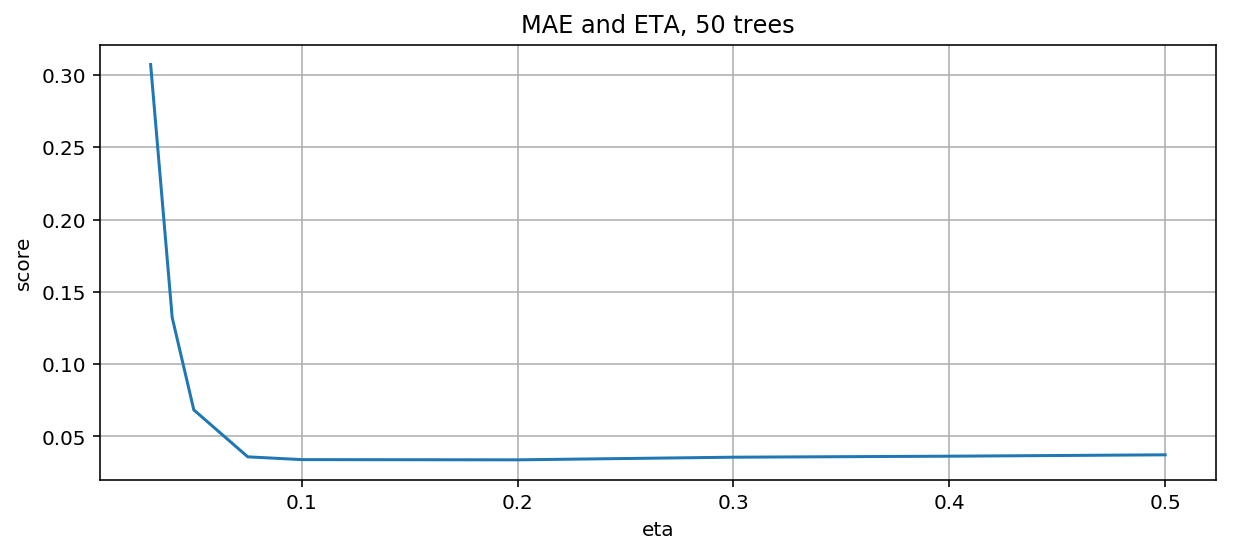

In [186]:
eta, y = convert_grid_scores(grid.grid_scores_)
eta = xgb_param_grid['eta']
plt.figure(figsize=(10,4))
plt.title('MAE and ETA, 50 trees')
plt.xlabel('eta')
plt.ylabel('score')
plt.plot(eta, -y)
plt.grid(True)
plt.show()

In [187]:
%%time

if USE_PRETRAINED:
    with open('pretrained/xgb_grid_search_eta_100.pkl', 'rb') as f:
        grid = pickle.load(f)
else:
    xgb_param_grid = {'eta':[0.5,0.4,0.3,0.2,0.1,0.075,0.05,0.04,0.03]}
    grid = GridSearchCV(XGBoostRegressor(num_boost_round=100, gamma=0.2, max_depth=8, min_child_weight=6,
                                         colsample_bytree=0.6, subsample=0.9),
                        param_grid=xgb_param_grid, cv=5, scoring=mse_scorer)

    grid.fit(x_train, y_train)

Wall time: 2.71 s


In [188]:
grid.grid_scores_, grid.best_params_, grid.best_score_

([mean: -0.03732, std: 0.00744, params: {'eta': 0.5},
  mean: -0.03704, std: 0.00744, params: {'eta': 0.4},
  mean: -0.03563, std: 0.00651, params: {'eta': 0.3},
  mean: -0.03385, std: 0.00607, params: {'eta': 0.2},
  mean: -0.03376, std: 0.00641, params: {'eta': 0.1},
  mean: -0.03329, std: 0.00616, params: {'eta': 0.075},
  mean: -0.03327, std: 0.00669, params: {'eta': 0.05},
  mean: -0.03490, std: 0.00756, params: {'eta': 0.04},
  mean: -0.04732, std: 0.00948, params: {'eta': 0.03}],
 {'eta': 0.05},
 -0.033269929298032616)

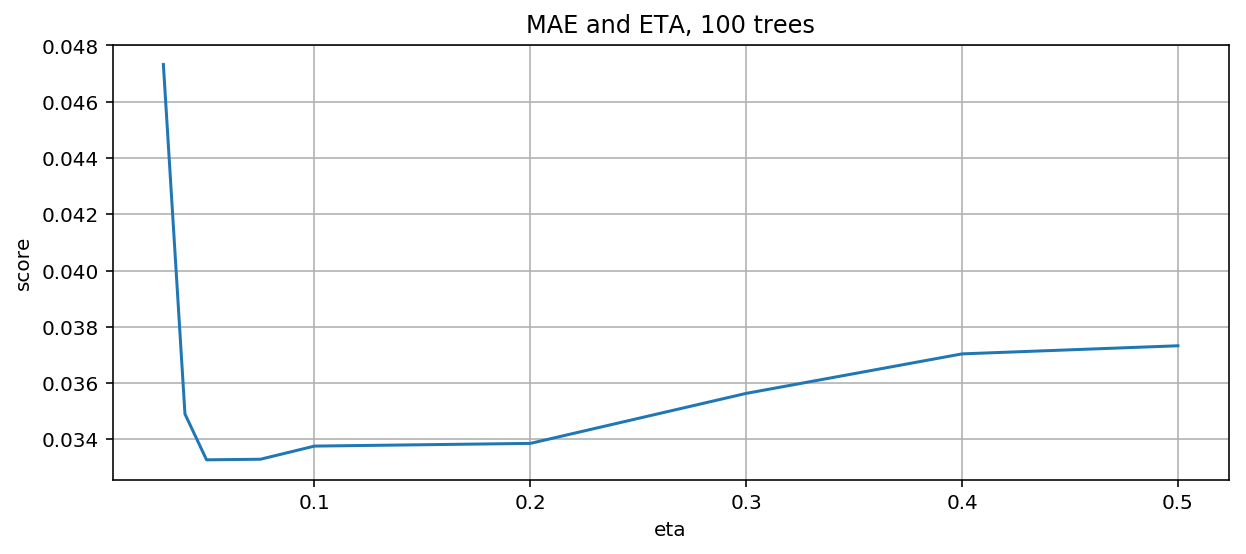

In [190]:
eta, y = convert_grid_scores(grid.grid_scores_)
eta = xgb_param_grid['eta']
plt.figure(figsize=(10,4))
plt.title('MAE and ETA, 100 trees')
plt.xlabel('eta')
plt.ylabel('score')
plt.plot(list(eta), -y)
plt.grid(True)
plt.show()

In [192]:
%%time

if USE_PRETRAINED:
    with open('pretrained/xgb_grid_search_eta_200.pkl', 'rb') as f:
        grid = pickle.load(f)
else:
    xgb_param_grid = {'eta':[0.09,0.08,0.07,0.06,0.05,0.04]}
    grid = GridSearchCV(XGBoostRegressor(num_boost_round=200, gamma=0.2, max_depth=8, min_child_weight=6,
                                         colsample_bytree=0.6, subsample=0.9),
                        param_grid=xgb_param_grid, cv=5, scoring=mse_scorer)

    grid.fit(x_train, y_train)

Wall time: 3.85 s


In [193]:
grid.grid_scores_, grid.best_params_, grid.best_score_

([mean: -0.03321, std: 0.00632, params: {'eta': 0.09},
  mean: -0.03253, std: 0.00625, params: {'eta': 0.08},
  mean: -0.03323, std: 0.00638, params: {'eta': 0.07},
  mean: -0.03249, std: 0.00625, params: {'eta': 0.06},
  mean: -0.03290, std: 0.00627, params: {'eta': 0.05},
  mean: -0.03309, std: 0.00632, params: {'eta': 0.04}],
 {'eta': 0.06},
 -0.032492343205765495)

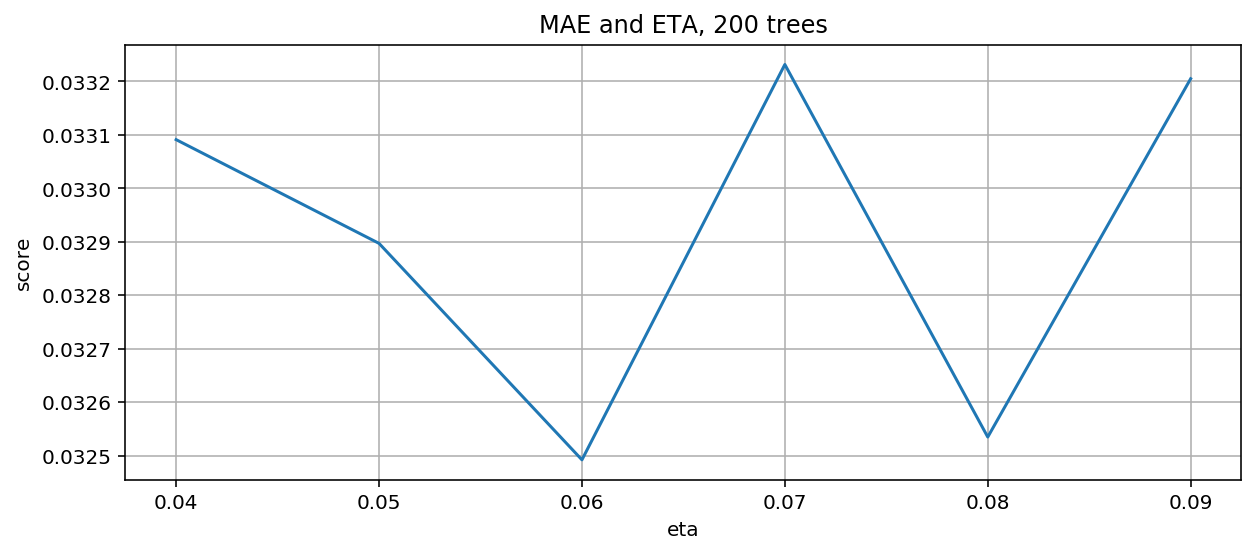

In [195]:
eta, y = convert_grid_scores(grid.grid_scores_)
eta = xgb_param_grid['eta']
plt.figure(figsize=(10,4))
plt.title('MAE and ETA, 200 trees')
plt.xlabel('eta')
plt.ylabel('score')
plt.plot(eta, -y)
plt.grid(True)
plt.show()

In [197]:
%%time

# Final XGBoost model

if USE_PRETRAINED:
    with open('pretrained/xgb_cv_eta_200.pkl', 'rb') as f:
        cv = pickle.load(f)
else:
    bst = XGBoostRegressor(num_boost_round=200, eta=0.07, gamma=0.2, max_depth=8, min_child_weight=6,
                                         colsample_bytree=0.6, subsample=0.9)
    cv = bst.kfold(x_train, y_train, nfold=5)

Wall time: 983 ms


In [198]:
cv

test-mae-mean      2.439763
test-mae-std       0.115336
test-rmse-mean     0.175478
test-rmse-std      0.009657
train-mae-mean     1.799010
train-mae-std      0.017188
train-rmse-mean    0.128194
train-rmse-std     0.001006
Name: 160, dtype: float64

In [ ]:
xgb_params = {
    'seed': 0,
    'eta': 0.1,
    'learning_rate':0.02,
    'colsample_bytree': 0.5,
    'silent': 1,
    'subsample': 0.7,
    'objective': 'reg:linear',
    'max_depth': 3,
    'min_child_weight': 3,
    'reg_lambda':0,'reg_alpha':10
}

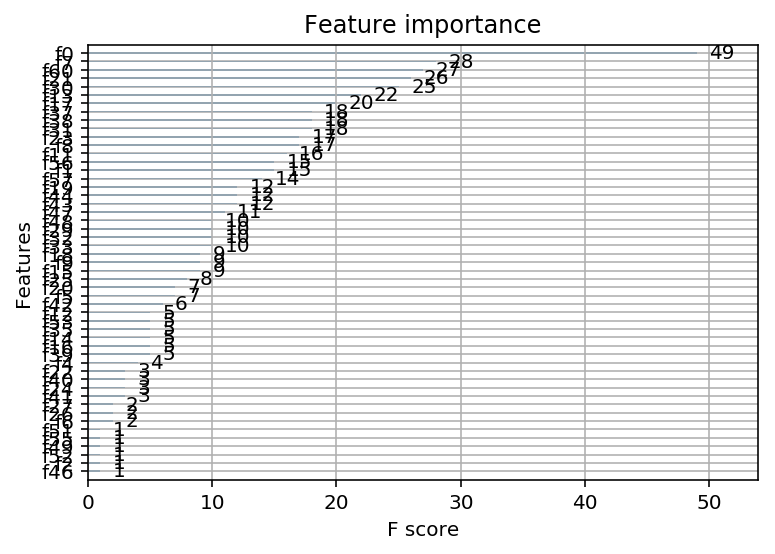

[ 0.08990826  0.02752294  0.00183486  0.          0.00733945  0.01284404
  0.00366972  0.05137615  0.03119266  0.01651376  0.          0.0293578
  0.00917431  0.04036697  0.00917431  0.01651376  0.00917431  0.03669725
  0.01651376  0.02201835  0.01284404  0.04770642  0.00550459  0.03119266
  0.00550459  0.0146789   0.00366972  0.00366972  0.          0.01834862
  0.04587156  0.03302752  0.01834862  0.01834862  0.          0.00917431
  0.          0.03302752  0.03302752  0.00917431  0.00550459  0.00550459
  0.01100917  0.02201835  0.02201835  0.          0.00183486  0.02018349
  0.01834862  0.00183486  0.          0.00183486  0.00183486  0.00917431
  0.          0.00183486  0.02752294  0.02568807  0.          0.
  0.04954128  0.        ]


In [234]:
from xgboost import plot_importance
import matplotlib.pyplot as pyplot
from xgboost import XGBRegressor
from sklearn import metrics
model_XGB=XGBRegressor()
model_XGB.fit(x_train,y_train)
plot_importance(model_XGB)
pyplot.show()
pyplot.savefig('D:\\feture_importance.svg',format='svg')
print(model_XGB.feature_importances_)